<a href="https://colab.research.google.com/github/rupam1123/Enviromental_Sound_Classification_Deep-Learning-Group-soundify-/blob/main/training_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import pickle
import copy
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/My Drive/UrbanSound8K/UrbanSound8K"
print(os.listdir(dataset_path))
print("success")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.DS_Store', 'FREESOUNDCREDITS.txt', 'UrbanSound8K_README.txt', 'audio', 'metadata', 'extracted_features.pkl', 'mymod.keras']
success


In [3]:
import os
import pickle
file_path = os.path.join("/content/drive/My Drive/UrbanSound8K/UrbanSound8K", "extracted_features.pkl")
try:
    with open(file_path, "rb") as f:
       e = pickle.load(f)
    print(e[2000])
except FileNotFoundError:
    print(f"Error: File not found at path: {file_path}")

[array([-249.17468   ,  121.08595   ,  -26.202131  ,   16.758747  ,
        -26.660133  ,    8.015966  ,  -20.04166   ,    0.88130635,
        -12.120513  ,   -2.8802943 ,   -9.437814  ,   -2.3489835 ,
         -9.316849  ,    4.317885  ,   -9.360911  ,    5.8921328 ,
         -0.74859846,    2.1623762 ,    3.3490613 ,    3.0717578 ,
          0.41532075,    4.9105206 ,    0.75348467,    4.611424  ,
         -0.30823827,    1.6950068 ,    0.35389802,    1.1151818 ,
          1.4040352 ,    3.6751547 ,   -1.7758421 ,    1.8446143 ,
         -1.2899519 ,    1.2524778 ,    1.7153963 ,    1.092661  ,
          0.3540919 ,    2.347103  ,    0.7745293 ,    3.397923  ],
      dtype=float32), 'gun_shot']


In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
e_df = pd.DataFrame(e, columns=["feature", "class"])

X=np.array(e_df['feature'].tolist())
y=np.array(e_df['class'].tolist())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [5]:
X.shape

(7970, 40)

In [6]:
y,"and",y.shape

(array(['dog_bark', 'children_playing', 'children_playing', ...,
        'car_horn', 'car_horn', 'car_horn'], dtype='<U16'),
 'and',
 (7970,))

In [7]:
print("y shape:", y.shape)
print("y data type:", type(y))
print(y[:10])  # Print first 10 values


y shape: (7970,)
y data type: <class 'numpy.ndarray'>
['dog_bark' 'children_playing' 'children_playing' 'children_playing'
 'children_playing' 'children_playing' 'children_playing'
 'children_playing' 'children_playing' 'car_horn']


In [8]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 40
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post', dtype='float32')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post', dtype='float32')
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test = to_categorical(y_test, num_classes=len(label_encoder.classes_))


In [9]:
X_train = np.squeeze(X_train, axis=(-1,))
X_test = np.squeeze(X_test, axis=(-1,))

print("Fixed X_train shape:", X_train.shape)
print("Fixed X_test shape:", X_test.shape)


Fixed X_train shape: (6376, 40)
Fixed X_test shape: (1594, 40)


In [10]:
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (6376, 40) (6376, 10)
Testing set size: (1594, 40) (1594, 10)


In [11]:
"success"

'success'

# CNN Model

In [24]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    # First Convolutional Block
    Conv1D(64, 3, activation='relu', input_shape=(40, 1), kernel_regularizer=l2(0.001)),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.3),

    # Second Convolutional Block
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.3),

    # Third Convolutional Block
    Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.4),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 19, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 324,746 (1.24 MB)

 Trainable params: 323,850 (1.24 MB)

 Non-trainable params: 896 (3.50 KB)

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [14]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6376, 40, 1)
X_test shape: (1594, 40, 1)
y_train shape: (6376, 10)
y_test shape: (1594, 10)


In [30]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[lr, early_stop]
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2425 - loss: 3.3243 - val_accuracy: 0.3613 - val_loss: 2.3897 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3892 - loss: 2.3694 - val_accuracy: 0.5337 - val_loss: 2.0858 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4457 - loss: 2.1885 - val_accuracy: 0.5909 - val_loss: 1.8899 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5149 - loss: 1.9950 - val_accuracy: 0.6528 - val_loss: 1.6960 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5450 - loss: 1.8904 - val_accuracy: 0.6599 - val_loss: 1.6065 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5879 - loss: 1.8009 - val_accuracy: 0.7202 - val_loss: 1.4739 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6002 - loss: 1.7048 - val_acc

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100}%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9191 - loss: 0.6065
Test Loss: 0.6332206130027771
Test Accuracy: 90.15056490898132%


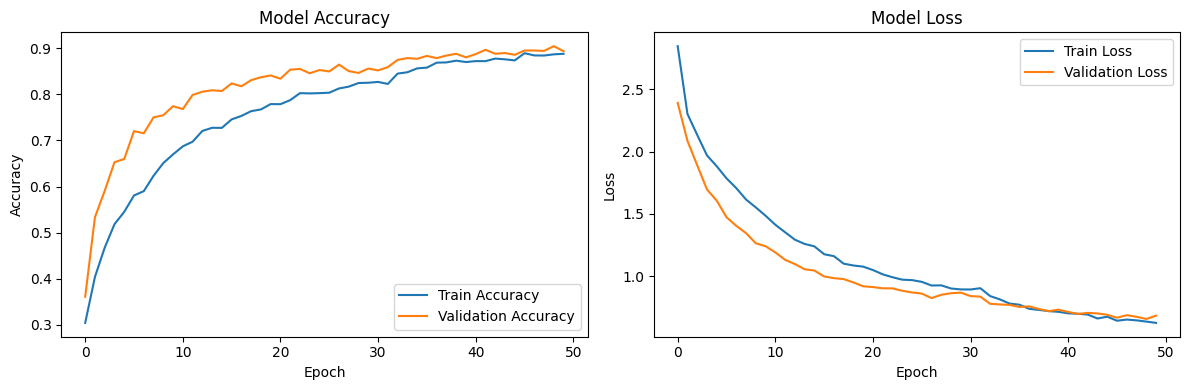

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
model.save('mymod.keras')

In [35]:
model_save_path = '/content/drive/My Drive/UrbanSound8K/UrbanSound8K/mymod.keras'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/UrbanSound8K/UrbanSound8K/mymod.keras


In [36]:
from tensorflow.keras.models import load_model
loaded_model = load_model('mymod.keras')


In [37]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]


Saving mixkit-dog-barking-twice-1.wav to mixkit-dog-barking-twice-1 (3).wav


In [38]:
!pip install resampy
import librosa
import resampy
def predict_audio_class(file_name):

    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)

    mfccs_scaled = mfccs_scaled.reshape(1, 40, 1)

    # Predict
    prediction = loaded_model.predict(mfccs_scaled)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

    return predicted_label[0]

predicted_class = predict_audio_class(file_name)
print(f"The predicted class is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
The predicted class is: dog_bark


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


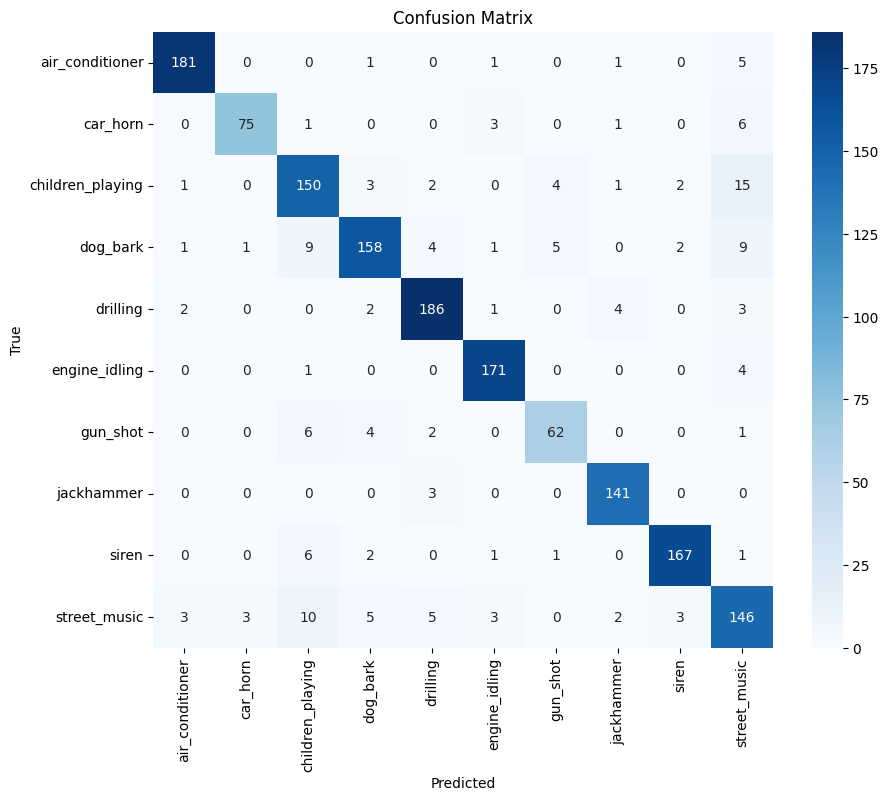

                  precision    recall  f1-score   support

 air_conditioner       0.96      0.96      0.96       189
        car_horn       0.95      0.87      0.91        86
children_playing       0.82      0.84      0.83       178
        dog_bark       0.90      0.83      0.87       190
        drilling       0.92      0.94      0.93       198
   engine_idling       0.94      0.97      0.96       176
        gun_shot       0.86      0.83      0.84        75
      jackhammer       0.94      0.98      0.96       144
           siren       0.96      0.94      0.95       178
    street_music       0.77      0.81      0.79       180

        accuracy                           0.90      1594
       macro avg       0.90      0.90      0.90      1594
    weighted avg       0.90      0.90      0.90      1594



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
